In [ ]:
!pip install kaggle

In [ ]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [ ]:
kaggle_credentials = json.load(open("kaggle.json"))

In [ ]:
os.environ['KAGGLE_USERNAME'] = kaggle_credentials["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentials["key"]

In [ ]:
!kaggle datasets download -d gpiosenka/cards-image-datasetclassification


Dataset URL: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification
License(s): CC0-1.0
 87% 334M/385M [00:00<00:00, 631MB/s]
100% 385M/385M [00:00<00:00, 582MB/s]


In [ ]:
!unzip cards-image-datasetclassification.zip -d cards_dataset


Archive:  cards-image-datasetclassification.zip
replace cards_dataset/14card types-14-(200 X 200)-94.61.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace cards_dataset/53cards-53-(200 X 200)-100.00.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace cards_dataset/cards.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace cards_dataset/test/ace of clubs/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
class PlayingCardDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data = ImageFolder(data_dir, transform=transform)

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    return self.data[idx]

  def classes(self):
    return self.data.classes


In [ ]:
dataset = PlayingCardDataset(
    data_dir = '/content/cards_dataset/train'
)

In [ ]:
len(dataset)

7624

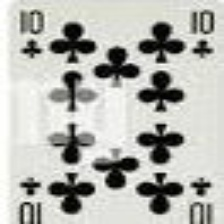

In [ ]:
image, label = dataset[6000]
image

In [ ]:
data_dir = '/content/cards_dataset/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

dataset = PlayingCardDataset(data_dir, transform)

In [ ]:
dataset[100]

In [ ]:
image , label = dataset[100]
image.shape

In [ ]:
for image, lavel in dataset:
  break

In [ ]:
dataloader = DataLoader(dataset, batch_size = 32, shuffle=True)

In [ ]:
for images, labels in dataloader:
  break

In [ ]:
images.shape

In [ ]:
class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifer, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output


In [ ]:
model = SimpleCardClassifer(num_classes = 53)

In [ ]:
print(model)

In [ ]:
out = model(images)
out.shape

torch.Size([32, 53])

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [ ]:
criterion(out,labels)

tensor(4.0088, grad_fn=<NllLossBackward0>)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '/content/cards_dataset/train'
valid_folder = '/content/cards_dataset/valid'
test_folder = '/content/cards_dataset/test'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
from tqdm import tqdm
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifer(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Validation loop: 100%|██████████| 9/9 [00:00<00:00, 16.92it/s]


Epoch 1/5 - Train loss: 1.5330784664824526, Validation loss: 0.2816287450070651


Validation loop: 100%|██████████| 9/9 [00:00<00:00, 15.87it/s]


Epoch 2/5 - Train loss: 0.5450527428454892, Validation loss: 0.20030385818121568


Validation loop: 100%|██████████| 9/9 [00:00<00:00, 19.08it/s]


Epoch 3/5 - Train loss: 0.3602354880520079, Validation loss: 0.1693424715186065


Validation loop: 100%|██████████| 9/9 [00:00<00:00, 15.85it/s]


Epoch 4/5 - Train loss: 0.2575134602917704, Validation loss: 0.19926712265554464


Validation loop: 100%|██████████| 9/9 [00:00<00:00, 18.08it/s]

Epoch 5/5 - Train loss: 0.1693637855585512, Validation loss: 0.09924151503814842


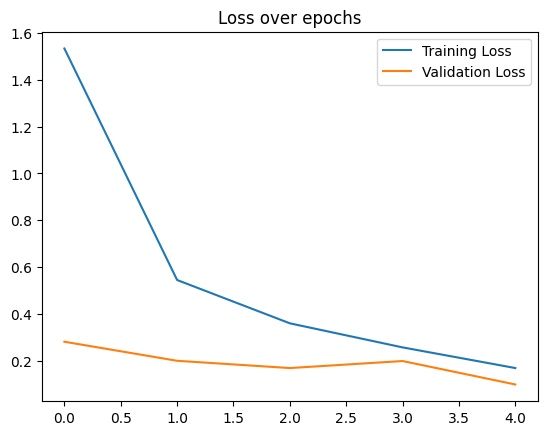

In [ ]:
plt.plot(train_losses, label = 'Training Loss')
plt.plot(val_losses, label = 'Validation Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

In [ ]:
import torch

torch.save(model.state_dict(), 'playing_cards_prediction_model.pth')

